# TUTORIAL 2
## Multi-Class Classification Using The Flux.jl Package On MNIST Data

### Preliminaries: Include packages and user-defined functions

In [1]:
using LinearAlgebra, Random, Statistics, Flux
using Flux: crossentropy, onecold, onehotbatch, throttle
using Base.Iterators: repeated
include("myJuliaLib/MNIST.jl")         # contains function `dispMNISTPatches`
include("myJuliaLib/readclassjson.jl") # contains function `readclassjson`

readclassjson (generic function with 1 method)

### Load training and test data from JSON files

In [2]:
cd(@__DIR__)
isfile("MNIST_train.json") || MNIST2json()

MNIST_train = readclassjson("JSON/MNIST_train.json")
MNIST_test  = readclassjson("JSON/MNIST_test.json")

Dict{Any, Any} with 2 entries:
  "X" => [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]
  "y" => [7, 2, 1, 0, 4, 1, 4, 9, 5, 9  …  7, 8, 9, 0, 1, 2, 3, 4, 5, 6]

### Embed data by scaling pixel values to appear on the [0,1] interval 

In [3]:
# 1. SCALE FEATURES BY 255 SO THAT PIXEL VALUES ARE IN THE RANGE (0,1)
x_train = MNIST_train["X"]/255
x_test  = MNIST_test["X"]/255

# 2. ONE-HOT ENCODE OUTCOMES 
y_train = MNIST_train["y"];
y_test = MNIST_test["y"];
Y_train = onehotbatch(y_train, 0:9)
Y_test  = onehotbatch(y_test, 0:9);

Ntrain, d = size(x_train)
Ntest = length(y_test)

10000

### Reduce dimension performing Principal Component Analysis (PCA)

In [4]:
# Demean the data and perform SVD
x_demean = [x_train; x_test] .- mean([x_train; x_test], dims = 1) 
Ftrain = svd((x_demean' * x_demean) / size(x_demean, 1))
lambdas = cumsum(Ftrain.S)/sum(Ftrain.S)     # variance contributed to by first k components, k = 1:d
k = searchsortedfirst(lambdas, 0.99)         # find number of components to retain
xPCA = x_demean * Ftrain.U[:,1:k];           # reduced dimension representation of training data

xPCA_train = xPCA[1:Ntrain, :]
xPCA_test  = xPCA[Ntrain+1:Ntrain+Ntest, :];

### Train a multi-layer perceptron (that is, a multi-layer neural network) on the reduced-dimension training data 

In [5]:
# Define NN model
model = Chain(Dense(d, 32, sigmoid),
              Dense(32, 10), softmax)

# Define loss function
loss(x, y) = crossentropy(model(x), y) 

# Define optimizer
optimiser = Descent(0.1)
# optimiser = ADAM()

# Create iterator to train model over 110 epochs. 
# 110 epochs gives a test (and train) accuracy of ~71% 
# when using gradient descent with lambda = 0.1. 
# Try going up to 500 epochs, or using other solvers
# like ADAM, but this may take a while. 
dataset = Iterators.repeated((x_train', Y_train), 110)

# Call back
accuracy(x, y) = mean(onecold(model(x)) .== onecold(y))
evalcb() = @show(accuracy(x_train', Y_train), accuracy(x_test', Y_test))

# Train model on data set
Flux.train!(loss, params(model), dataset, optimiser, cb = throttle(evalcb, 5))

accuracy(x_train', Y_train) = 0.09961666666666667
accuracy(x_test', Y_test) = 0.0968
accuracy(x_train', Y_train) = 0.1478
accuracy(x_test', Y_test) = 0.1462
accuracy(x_train', Y_train) = 0.17653333333333332
accuracy(x_test', Y_test) = 0.1767
accuracy(x_train', Y_train) = 0.21995
accuracy(x_test', Y_test) = 0.2212
accuracy(x_train', Y_train) = 0.32588333333333336
accuracy(x_test', Y_test) = 0.3248
accuracy(x_train', Y_train) = 0.43291666666666667
accuracy(x_test', Y_test) = 0.437
accuracy(x_train', Y_train) = 0.48086666666666666
accuracy(x_test', Y_test) = 0.484
accuracy(x_train', Y_train) = 0.5231166666666667
accuracy(x_test', Y_test) = 0.5264
accuracy(x_train', Y_train) = 0.5514
accuracy(x_test', Y_test) = 0.552
accuracy(x_train', Y_train) = 0.5728333333333333
accuracy(x_test', Y_test) = 0.5699
accuracy(x_train', Y_train) = 0.5897333333333333
accuracy(x_test', Y_test) = 0.5895
accuracy(x_train', Y_train) = 0.6030166666666666
accuracy(x_test', Y_test) = 0.6043
accuracy(x_train', Y_trai

### Validate the model by applying it on to test data and measuring accuracy

In [6]:
# Calculate confusion matrix on training and test data
function confusion_matrix(X, y)
    ŷ = onehotbatch(onecold(model(X)) .- 1, 0:9)
    y * ŷ'
end
display(confusion_matrix(x_train', Y_train))
display(confusion_matrix(x_test', Y_test))

10×10 Matrix{Int64}:
 5616    12    33    84    27     3   101    13    30     4
    0  6645    26    38     2     2    14     8     3     4
  210   782  4039   294   137     0   234   187    65    10
   86   335   168  4877     7    30    65   137   319   107
   28   265    27    13  3916     0   101    72     2  1418
  623   581    89  1793   313  1056   277   117   329   243
  225   257   159   100   155    10  5009     0     2     1
  131   417    54    11   159     0    12  5359     2   120
  218  1131   134  1100    69    56   113   169  2485   376
   98   300    62   122   826     0     7   657    22  3855

10×10 Matrix{Int64}:
 936     0    7   14    5    0   14    1    3    0
   0  1122    3    5    0    0    4    1    0    0
  37   164  660   62   21    1   35   32   20    0
   4    38   22  854    1    1    9   25   47    9
   2    50    7    2  634    0   24    6    0  257
  92    72   11  296   44  200   45   29   61   42
  55    27   29   18   33    2  793    1    0    0
  12    74   16    0   16    0    2  881    2   25
  48   130   17  209   13    6   24   40  423   64
  24    38   10   16  137    0    1   86    6  691

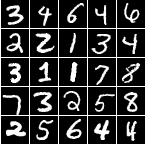

5×5 Matrix{Int64}:
 3  4  6  4  6
 2  2  1  3  4
 3  1  1  7  8
 7  3  2  5  8
 2  5  6  4  4

Training accuracy = 71.42833333333334%
Test accuracy = 71.94%


In [7]:
# Display a patch of randomly chosen images from the test set
patchSize = 5
randIndx = randperm(MersenneTwister(724629), size(x_test,1))
randIndx = randIndx[1:patchSize^2] 
IM_test  = dispMNISTPatches(x_test[randIndx, :], patchSize)
display(IM_test)

# Predict outcome for test set
yhat_test = onecold(model(x_test')) .- 1
display(reshape(y_test[randIndx], patchSize, patchSize))

# Print overall accuracy
println("Training accuracy = ", accuracy(x_train', Y_train)*100, "%\nTest accuracy = ", accuracy(x_test', Y_test)*100, "%")